In [1]:
import os, utils, warnings
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

from functools import reduce
from statsmodels.formula.api import ols
from nilearn import datasets
from glob import glob

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
pd.options.display.max_columns=300

DATAPATH = "../abcd-data-release-5.1/core/"
atlas_to_use = 'glasser'

ATLASPATH = "T1stats/HCP/"
FNAME = 'thickness.HCP-MMP1'

# setup some save directories
if not os.path.exists(os.path.join("./plots", atlas_to_use)):
    os.makedirs(os.path.join("./plots", atlas_to_use))

if not os.path.exists(os.path.join("./stats", atlas_to_use)):
    os.makedirs(os.path.join("./stats", atlas_to_use))

followups_to_keep = ['baselineyear1arm1', '2yearfollowupyarm1', '4yearfollowupyarm1']

mpl.rcParams['xtick.labelsize'] = 12 
mpl.rcParams['ytick.labelsize'] = 12 
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['axes.titlesize'] = 13

# define the colors for the figures.
colors = sns.color_palette(palette=[[12/255, 123/255, 220/255], 
                                    [216/255, 27/255, 96/255]])

## Load demographic data that we want

We want:
1. race
2. age
3. sex
4. bmi (we need to compute that from the weight and height)

In [2]:
# get sex and ethnicity from the <<abcd_p_demo.csv>> file
demo1 = pd.read_csv(os.path.join(DATAPATH, 'abcd-general', 'abcd_p_demo.csv'), usecols=['src_subject_id', 'eventname', 'demo_sex_v2', 'race_ethnicity'])
demo1.rename(columns={'demo_sex_v2': 'sex'}, inplace=True)

for i in ['sex', 'race_ethnicity']:
    demo1[i] = demo1.groupby('src_subject_id')[i].ffill()

demo1 = utils.adjust_sub_and_event_column(demo1)
demo1 = demo1.loc[demo1['eventname'].isin(followups_to_keep), :].reset_index(drop=True)
demo1.groupby('eventname').describe()

sex                                               \
                      count      mean       std  min  25%  50%  75%  max   
eventname                                                                  
2yearfollowupyarm1  10908.0  1.475523  0.499974  1.0  1.0  1.0  2.0  3.0   
4yearfollowupyarm1   4688.0  1.476323  0.499919  1.0  1.0  1.0  2.0  3.0   
baselineyear1arm1   11868.0  1.478851  0.500079  1.0  1.0  1.0  2.0  3.0   

                   race_ethnicity                                               
                            count      mean       std  min  25%  50%  75%  max  
eventname                                                                       
2yearfollowupyarm1        10908.0  2.019435  1.327395  1.0  1.0  1.0  3.0  5.0  
4yearfollowupyarm1         4688.0  1.980802  1.324972  1.0  1.0  1.0  3.0  5.0  
baselineyear1arm1         11866.0  2.040620  1.323852  1.0  1.0  1.0  3.0  5.0

In [3]:
# get the interview age from the <<abcd_y_lt.csv>> file
demo2 = pd.read_csv(os.path.join(DATAPATH, 'abcd-general', 'abcd_y_lt.csv'), usecols=['src_subject_id', 'eventname', 'interview_age'])
demo2.rename(columns={'interview_age': 'age'}, inplace=True)
demo2 = utils.adjust_sub_and_event_column(demo2)
demo2 = demo2.loc[demo2['eventname'].isin(followups_to_keep), :].reset_index(drop=True)
demo2.groupby('eventname').describe()

age                                                    \
                      count        mean       std    min    25%    50%    75%   
eventname                                                                       
2yearfollowupyarm1  10972.0  144.319358  8.029109  127.0  138.0  144.0  151.0   
4yearfollowupyarm1   4754.0  168.975389  8.169621  150.0  162.0  169.0  176.0   
baselineyear1arm1   11867.0  118.978259  7.496009  107.0  112.0  119.0  126.0   

                           
                      max  
eventname                  
2yearfollowupyarm1  168.0  
4yearfollowupyarm1  189.0  
baselineyear1arm1   133.0

In [4]:
# compute the BMI from the <<ph_y_anthro.csv>> file
bmi_info = pd.read_csv(os.path.join(DATAPATH, 'physical-health', 'ph_y_anthro.csv'), usecols=['src_subject_id', 'eventname', 'anthro_1_height_in', 'anthro2heightin', 'anthroweight1lb', 'anthroweight2lb'])
bmi_info['avg_height12'] = bmi_info[['anthro_1_height_in', 'anthro2heightin']].mean(axis=1, skipna=True)
bmi_info['avg_weight12'] = bmi_info[['anthroweight1lb', 'anthroweight2lb']].mean(axis=1, skipna=True)

demo3 = bmi_info.iloc[:, :2]
demo3['bmi'] = bmi_info["avg_weight12"] / (bmi_info["avg_height12"]**2) * 703

# retain participants with 10 <= bmi <=50
demo3 = demo3[demo3.bmi.between(10, 50, inclusive='both')]

demo3 = utils.adjust_sub_and_event_column(demo3)
demo3 = demo3.loc[demo3['eventname'].isin(followups_to_keep), :].reset_index(drop=True)
demo3.groupby('eventname').describe()

bmi                                             \
                      count       mean       std        min        25%   
eventname                                                                
2yearfollowupyarm1   9138.0  20.739856  4.963841  10.812902  17.192459   
4yearfollowupyarm1   4162.0  22.613249  5.572786  10.005969  18.739142   
baselineyear1arm1   11829.0  18.831659  4.181060  10.058533  15.946559   

                                                     
                          50%        75%        max  
eventname                                            
2yearfollowupyarm1  19.436544  22.949910  49.421782  
4yearfollowupyarm1  21.107029  25.107645  49.492802  
baselineyear1arm1   17.662149  20.659592  45.616889

In [5]:
# get the scan site from the <<"imaging/mri_y_adm_info.csv">> file
site_info = pd.read_csv(os.path.join(DATAPATH, 'imaging', 'mri_y_adm_info.csv'), usecols=['src_subject_id', 'eventname', 'mri_info_deviceserialnumber'])
site_info.rename(columns={'mri_info_deviceserialnumber': 'site'}, inplace=True)
site_info = utils.adjust_sub_and_event_column(site_info)
site_info = site_info.loc[site_info['eventname'].isin(followups_to_keep), :].reset_index(drop=True)
site_info.groupby('eventname').describe()

src_subject_id                                site         \
                            count unique              top freq  count unique   
eventname                                                                      
2yearfollowupyarm1           8123   8123  NDARINV00CY2MDM    1   8123     28   
4yearfollowupyarm1           3045   3045  NDARINV00CY2MDM    1   3045     26   
baselineyear1arm1           11771  11771  NDARINV003RTV85    1  11771     29   

                                        
                             top  freq  
eventname                               
2yearfollowupyarm1  HASH3935c89e   743  
4yearfollowupyarm1  HASH3935c89e   257  
baselineyear1arm1   HASH3935c89e  1011

In [6]:
# merge into a single dataframe
on=['src_subject_id', 'eventname']
demographics = reduce(lambda left, right: pd.merge(left, right, on=on), [demo1, demo2, demo3, site_info])
demographics.groupby(["eventname"]).describe()

sex                                               \
                      count      mean       std  min  25%  50%  75%  max   
eventname                                                                  
2yearfollowupyarm1   8082.0  1.460035  0.498679  1.0  1.0  1.0  2.0  3.0   
4yearfollowupyarm1   3005.0  1.470216  0.499862  1.0  1.0  1.0  2.0  3.0   
baselineyear1arm1   11734.0  1.478268  0.500060  1.0  1.0  1.0  2.0  3.0   

                   race_ethnicity                                          \
                            count      mean       std  min  25%  50%  75%   
eventname                                                                   
2yearfollowupyarm1         8082.0  1.992824  1.325111  1.0  1.0  1.0  3.0   
4yearfollowupyarm1         3005.0  1.987687  1.337086  1.0  1.0  1.0  3.0   
baselineyear1arm1         11732.0  2.039720  1.325716  1.0  1.0  1.0  3.0   

                             age                                             \
                    max    count        mean       std    min    25%    50%   
eventname                                                                     
2yearfollowupyarm1  5.0   8082.0  143.422049  7.819801  127.0  137.0  143.0   
4yearfollowupyarm1  5.0   3005.0  168.870216  8.310378  150.0  162.0  169.0   
baselineyear1arm1   5.0  11734.0  118.973751  7.499004  107.0  112.0  119.0   

                                      bmi                                  \
                      75%    max    count       mean       std        min   
eventname                                                                   
2yearfollowupyarm1  150.0  166.0   8082.0  20.762858  4.954722  10.812902   
4yearfollowupyarm1  176.0  189.0   3005.0  22.955764  5.694065  10.005969   
baselineyear1arm1   126.0  133.0  11734.0  18.831548  4.181474  10.058533   

                                                                
                          25%        50%        75%        max  
eventname                                                       
2yearfollowupyarm1  17.194862  19.483497  23.022695  49.421782  
4yearfollowupyarm1  18.898927  21.416192  25.701207  49.492802  
baselineyear1arm1   15.947070  17.662149  20.653903  45.616889

In [7]:
# add the pubertal scores for the caregiver reports
reporter = 'caregiver'
reporter_sc = 'p'
demographics = utils.pubertal_scores(reporter, demographics)

model = f'PDS_mean_{reporter_sc} ~ age'
lm = ols(model, demographics).fit()

demographics[f"resid_std_{reporter_sc}"] = lm.resid / lm.resid.std()
demographics[f"pub_ontime_{reporter_sc}"] = demographics[f"resid_std_{reporter_sc}"].between(-1, 1, inclusive="neither")  # those cases between +- 1SD

demographics.groupby('eventname').describe()

sex                                               \
                      count      mean       std  min  25%  50%  75%  max   
eventname                                                                  
2yearfollowupyarm1   7502.0  1.456812  0.498164  1.0  1.0  1.0  2.0  2.0   
4yearfollowupyarm1   2819.0  1.459383  0.498436  1.0  1.0  1.0  2.0  2.0   
baselineyear1arm1   10844.0  1.478052  0.499541  1.0  1.0  1.0  2.0  2.0   

                   race_ethnicity                                          \
                            count      mean       std  min  25%  50%  75%   
eventname                                                                   
2yearfollowupyarm1         7502.0  1.976006  1.325138  1.0  1.0  1.0  3.0   
4yearfollowupyarm1         2819.0  1.978716  1.336383  1.0  1.0  1.0  3.0   
baselineyear1arm1         10843.0  2.014848  1.333331  1.0  1.0  1.0  3.0   

                             age                                             \
                    max    count        mean       std    min    25%    50%   
eventname                                                                     
2yearfollowupyarm1  5.0   7502.0  143.402026  7.838112  127.0  137.0  143.0   
4yearfollowupyarm1  5.0   2819.0  168.881873  8.293491  150.0  162.0  169.0   
baselineyear1arm1   5.0  10844.0  118.987366  7.493249  107.0  112.0  119.0   

                                      bmi                                  \
                      75%    max    count       mean       std        min   
eventname                                                                   
2yearfollowupyarm1  150.0  166.0   7502.0  20.718458  4.924920  10.812902   
4yearfollowupyarm1  176.0  189.0   2819.0  22.914787  5.637367  10.005969   
baselineyear1arm1   125.0  133.0  10844.0  18.740435  4.109068  10.058533   

                                                               PDS_mean_p  \
                          25%        50%        75%        max      count   
eventname                                                                   
2yearfollowupyarm1  17.184444  19.436544  22.960172  49.421782     7502.0   
4yearfollowupyarm1  18.892909  21.407067  25.666520  49.492802     2819.0   
baselineyear1arm1   15.916624  17.594880  20.512079  45.245994    10844.0   

                                                                PDS_cat_score  \
                        mean       std  min  25%  50%  75%  max         count   
eventname                                                                       
2yearfollowupyarm1  2.123780  0.703504  1.0  1.6  2.0  2.6  4.0        7502.0   
4yearfollowupyarm1  2.936219  0.587476  1.0  2.6  3.0  3.2  4.0        2819.0   
baselineyear1arm1   1.598543  0.477197  1.0  1.2  1.4  1.8  4.0       10844.0   

                                                                 resid_std_p  \
                        mean       std  min  25%  50%  75%   max       count   
eventname                                                                      
2yearfollowupyarm1  4.924953  1.646574  2.0  3.0  5.0  6.0  12.0      7502.0   
4yearfollowupyarm1  7.097907  1.642992  2.0  6.0  7.0  8.0  12.0      2819.0   
baselineyear1arm1   3.568794  1.267274  2.0  3.0  3.0  4.0  12.0     10844.0   

                                                                      \
                        mean       std       min       25%       50%   
eventname                                                              
2yearfollowupyarm1 -0.107125  1.182836 -2.794162 -1.054009 -0.222039   
4yearfollowupyarm1  0.231357  0.990836 -3.607361 -0.331668  0.329103   
baselineyear1arm1   0.013967  0.840705 -1.595765 -0.568567 -0.112411   

                                        
                         75%       max  
eventname                               
2yearfollowupyarm1  0.790516  3.766610  
4yearfollowupyarm1  0.918351  2.782212  
baselineyear1arm1   0.453374  4.708208

In [8]:
# lastly, add the euler numbers to the demographics
euler_full = pd.read_csv('./T1stats/allEuler.csv')
euler_full = utils.split_first_col_of_glasser(euler_full, drop_extra=False)

demographics = pd.merge(demographics, 
                        euler_full[["src_subject_id", "eventname", "euler_lh", "euler_rh"]], 
                        on=['src_subject_id', 'eventname'])

In [9]:
# comupte the socioeconomic status
ses_base = pd.read_csv(os.path.join(DATAPATH, 'abcd-general/abcd_p_demo.csv')) # there are no 2year follow up datacols = ["demo_prnt_ed_v2", "demo_comb_income_v2"]

cols = ["demo_prnt_ed_v2", "demo_comb_income_v2"]
ses_base[cols].replace([777, 999], np.nan, inplace=True) # replace refuse and dont know with nan

for col in cols:
    temp_array = np.array(ses_base[col]).reshape(-1,1) # palm_inormal requires 2D array
    ses_base[col] = utils.palm_inormal(temp_array)
ses_base["ses"] = ses_base[cols].mean(axis=1, skipna=True) # calculate mean to generate a single SES variable

ses_base = utils.adjust_sub_and_event_column(ses_base)

/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_58275/543540121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ses_base[cols].replace([777, 999], np.nan, inplace=True) # replace refuse and dont know with nan


In [10]:
demographics = pd.merge(demographics, 
                        ses_base[["src_subject_id", "eventname", "ses"]], 
                        on=['src_subject_id', 'eventname'])
demographics.sort_values(['src_subject_id', 'eventname'], ascending=[True, False], inplace=True)
demographics["ses"] = demographics.groupby('src_subject_id')["ses"].ffill()

In [11]:
# let's see the full demographics data
# remove those subjects that have a different sex than male or female
demographics = demographics[demographics.sex != 3.0]
demographics.groupby(['eventname', 'sex']).describe()

# we can now use whatever columns we like as covariates in the model / association analysis

race_ethnicity                                          \
                                count      mean       std  min  25%  50%  75%   
eventname          sex                                                          
2yearfollowupyarm1 1.0         3885.0  1.952381  1.324936  1.0  1.0  1.0  3.0   
                   2.0         3288.0  2.008212  1.332560  1.0  1.0  1.0  3.0   
4yearfollowupyarm1 1.0          694.0  1.851585  1.258571  1.0  1.0  1.0  3.0   
                   2.0          583.0  2.094340  1.412883  1.0  1.0  1.0  3.0   
baselineyear1arm1  1.0         5610.0  1.999109  1.334900  1.0  1.0  1.0  3.0   
                   2.0         5156.0  2.027347  1.331054  1.0  1.0  1.0  3.0   

                                age                                      \
                        max   count        mean       std    min    25%   
eventname          sex                                                    
2yearfollowupyarm1 1.0  5.0  3885.0  143.622394  7.814683  127.0  137.0   
                   2.0  5.0  3288.0  142.855839  7.737039  128.0  136.0   
4yearfollowupyarm1 1.0  5.0   694.0  169.412104  8.056272  152.0  163.0   
                   2.0  5.0   583.0  168.339623  7.889568  151.0  162.0   
baselineyear1arm1  1.0  5.0  5611.0  119.197647  7.501418  107.0  112.0   
                   2.0  5.0  5156.0  118.770559  7.478149  107.0  112.0   

                                                bmi                       \
                          50%    75%    max   count       mean       std   
eventname          sex                                                     
2yearfollowupyarm1 1.0  144.0  150.0  164.0  3885.0  20.418221  4.757971   
                   2.0  143.0  149.0  166.0  3288.0  20.993520  5.041236   
4yearfollowupyarm1 1.0  170.0  176.0  186.0   694.0  22.599779  5.748687   
                   2.0  168.0  175.0  187.0   583.0  23.691934  5.727550   
baselineyear1arm1  1.0  119.0  126.0  133.0  5611.0  18.640153  3.981500   
                   2.0  119.0  125.0  132.0  5156.0  18.837391  4.231884   

                                                                               \
                              min        25%        50%        75%        max   
eventname          sex                                                          
2yearfollowupyarm1 1.0  12.329401  17.049894  19.103443  22.677360  49.421782   
                   2.0  10.812902  17.345125  19.742945  23.284165  49.258651   
4yearfollowupyarm1 1.0  12.729218  18.664924  20.843540  25.193002  49.492802   
                   2.0  13.284203  19.400843  22.286550  26.639136  47.885010   
baselineyear1arm1  1.0  10.815385  15.940902  17.502633  20.299954  42.760992   
                   2.0  10.058533  15.885038  17.685603  20.772161  45.245994   

                       PDS_mean_p                                          \
                            count      mean       std  min  25%  50%  75%   
eventname          sex                                                      
2yearfollowupyarm1 1.0     3885.0  1.795367  0.558078  1.0  1.4  1.6  2.2   
                   2.0     3288.0  2.497506  0.662705  1.0  2.0  2.6  3.2   
4yearfollowupyarm1 1.0      694.0  2.640346  0.534185  1.0  2.4  2.8  3.0   
                   2.0      583.0  3.299485  0.422051  1.4  3.2  3.2  3.6   
baselineyear1arm1  1.0     5611.0  1.438781  0.368695  1.0  1.2  1.4  1.6   
                   2.0     5156.0  1.772420  0.518679  1.0  1.4  1.6  2.2   

                            PDS_cat_score                                     \
                        max         count      mean       std  min  25%  50%   
eventname          sex                                                         
2yearfollowupyarm1 1.0  4.0        3885.0  4.648391  1.803968  3.0  3.0  4.0   
                   2.0  4.0        3288.0  5.208333  1.351547  2.0  4.0  6.0   
4yearfollowupyarm1 1.0  4.0         694.0  7.661383  1.944180  3.0  7.0  8.0   
                   2.0  4.0 

# MRI data preprocessing and curation

The ABCD protocol comes with a quality control (QC) file.

We can use that file to eliminate some subjects already. However, since we preprocessed the data ourselves, we still need to check out if there are extreme outliers that we may want to further exclude.

In [12]:
# CHECK THE MRI_QC_INCLUDE FILE FROM ABCD
abcd_qc_file = pd.read_csv('../abcd-data-release-5.1/core/imaging/mri_y_qc_incl.csv', usecols=['src_subject_id', 'eventname', 'imgincl_t1w_include'])
abcd_qc_file = utils.adjust_sub_and_event_column(abcd_qc_file)
print(len(abcd_qc_file))
abcd_qc_file = abcd_qc_file[abcd_qc_file.imgincl_t1w_include==1]
print(len(abcd_qc_file))

22939
22166


It appears that 773 scans did not survive the ABCD QC. 


Now, for our analysis, we also need to make sure that 
* we have everything for each participant. 
* That includes 
    * thickness data (session 1/2), 
    * euler numbers, 
    * and demographics

## Select MRI data

In [13]:
# thickness data
lh_thickness = pd.read_table(os.path.join(ATLASPATH, 'lh.' + FNAME + '.txt'))
lh_thickness = utils.split_first_col_of_glasser(lh_thickness)
rh_thickness = pd.read_table(os.path.join(ATLASPATH, 'rh.' + FNAME + '.txt'))
rh_thickness = utils.split_first_col_of_glasser(rh_thickness)

# combine the dataframes of both hemispheres
thickness_full = pd.merge(lh_thickness, rh_thickness, on=['src_subject_id', 'eventname'])

In [14]:
thickness_full.groupby('eventname').describe()

lh_???_thickness                                      \
                              count      mean       std    min      25%   
eventname                                                                 
2yearfollowupyarm1           7763.0  0.560985  0.077390  0.088  0.50800   
4yearfollowupyarm1           1396.0  0.554668  0.085653  0.341  0.49975   
baselineyear1arm1           11727.0  0.567615  0.078875  0.277  0.51500   

                                         lh_L_V1_ROI_thickness            \
                       50%    75%    max                 count      mean   
eventname                                                                  
2yearfollowupyarm1  0.5560  0.608  1.140                7763.0  1.919749   
4yearfollowupyarm1  0.5495  0.601  1.835                1396.0  1.920775   
baselineyear1arm1   0.5630  0.615  1.171               11727.0  1.950930   

                                                                 \
                         std    min    25%    50%    75%    max   
eventname                                                         
2yearfollowupyarm1  0.130109  1.467  1.832  1.924  2.007  2.454   
4yearfollowupyarm1  0.128745  1.534  1.837  1.926  2.013  2.313   
baselineyear1arm1   0.130273  1.511  1.861  1.951  2.040  2.604   

                   lh_L_MST_ROI_thickness                                    \
                                    count      mean       std    min    25%   
eventname                                                                     
2yearfollowupyarm1                 7763.0  2.431911  0.184008  1.706  2.311   
4yearfollowupyarm1                 1396.0  2.396148  0.178408  1.804  2.287   
baselineyear1arm1                 11727.0  2.463657  0.187837  1.556  2.344   

                                        lh_L_V6_ROI_thickness            \
                      50%    75%    max                 count      mean   
eventname                                                                 
2yearfollowupyarm1  2.426  2.544  3.514                7763.0  2.275878   
4yearfollowupyarm1  2.389  2.503  3.200                1396.0  2.227488   
baselineyear1arm1   2.458  2.575  3.356               11727.0  2.315537   

                                                                   \
                         std    min      25%    50%    75%    max   
eventname                                                           
2yearfollowupyarm1  0.154264  1.710  2.17500  2.277  2.378  2.977   
4yearfollowupyarm1  0.145454  1.741  2.13075  2.234  2.327  2.708   
baselineyear1arm1   0.158015  1.601  2.21300  2.318  2.419  3.264   

                   lh_L_V2_ROI_thickness                                    \
                                   count      mean       std    min    25%   
eventname                                                                    
2yearfollowupyarm1                7763.0  2.096003  0.122788  1.628  2.014   
4yearfollowupyarm1                1396.0  2.071198  0.121409  1.644  1.990   
baselineyear1arm1                11727.0  2.144918  0.122119  1.649  2.065   

                                        lh_L_V3_ROI_thickness            \
                      50%    75%    max                 count      mean   
eventname                                                                 
2yearfollowupyarm1  2.095  2.178  2.614                7763.0  2.295713   
4yearfollowupyarm1  2.073  2.154  2.517                1396.0  2.263447   
baselineyear1arm1   2.145  2.226  2.680               11727.0  2.335690   

                                                                    \
                         std    min      25%     50%    75%    max   
eventname                                                            
2yearfollowupyarm1  0.126239  1.755  2.21400  2.2990  2.382  2.840   
4yearfollowupyarm1  0.122348  1.758  2.18775  2.2675  2.347  2.606   
baselineyear1arm1   0.125725  1.577  2.25500  2.3390  2.419  2.871   

                   lh_L_V4

Since we need the T1 data for both sessions, we need to drop all those subejcts that only have a single one, and all other data > 2year follow up. 

### Combine demographics and MRI data

In [15]:
df_combined = pd.merge(demographics, thickness_full, on=['src_subject_id', 'eventname'])
df_combined.groupby(['eventname', 'sex']).describe()

race_ethnicity                                          \
                                count      mean       std  min  25%  50%  75%   
eventname          sex                                                          
2yearfollowupyarm1 1.0         3885.0  1.952381  1.324936  1.0  1.0  1.0  3.0   
                   2.0         3288.0  2.008212  1.332560  1.0  1.0  1.0  3.0   
4yearfollowupyarm1 1.0          694.0  1.851585  1.258571  1.0  1.0  1.0  3.0   
                   2.0          583.0  2.094340  1.412883  1.0  1.0  1.0  3.0   
baselineyear1arm1  1.0         5610.0  1.999109  1.334900  1.0  1.0  1.0  3.0   
                   2.0         5156.0  2.027347  1.331054  1.0  1.0  1.0  3.0   

                                age                                      \
                        max   count        mean       std    min    25%   
eventname          sex                                                    
2yearfollowupyarm1 1.0  5.0  3885.0  143.622394  7.814683  127.0  137.0   
                   2.0  5.0  3288.0  142.855839  7.737039  128.0  136.0   
4yearfollowupyarm1 1.0  5.0   694.0  169.412104  8.056272  152.0  163.0   
                   2.0  5.0   583.0  168.339623  7.889568  151.0  162.0   
baselineyear1arm1  1.0  5.0  5611.0  119.197647  7.501418  107.0  112.0   
                   2.0  5.0  5156.0  118.770559  7.478149  107.0  112.0   

                                                bmi                       \
                          50%    75%    max   count       mean       std   
eventname          sex                                                     
2yearfollowupyarm1 1.0  144.0  150.0  164.0  3885.0  20.418221  4.757971   
                   2.0  143.0  149.0  166.0  3288.0  20.993520  5.041236   
4yearfollowupyarm1 1.0  170.0  176.0  186.0   694.0  22.599779  5.748687   
                   2.0  168.0  175.0  187.0   583.0  23.691934  5.727550   
baselineyear1arm1  1.0  119.0  126.0  133.0  5611.0  18.640153  3.981500   
                   2.0  119.0  125.0  132.0  5156.0  18.837391  4.231884   

                                                                               \
                              min        25%        50%        75%        max   
eventname          sex                                                          
2yearfollowupyarm1 1.0  12.329401  17.049894  19.103443  22.677360  49.421782   
                   2.0  10.812902  17.345125  19.742945  23.284165  49.258651   
4yearfollowupyarm1 1.0  12.729218  18.664924  20.843540  25.193002  49.492802   
                   2.0  13.284203  19.400843  22.286550  26.639136  47.885010   
baselineyear1arm1  1.0  10.815385  15.940902  17.502633  20.299954  42.760992   
                   2.0  10.058533  15.885038  17.685603  20.772161  45.245994   

                       PDS_mean_p                                          \
                            count      mean       std  min  25%  50%  75%   
eventname          sex                                                      
2yearfollowupyarm1 1.0     3885.0  1.795367  0.558078  1.0  1.4  1.6  2.2   
                   2.0     3288.0  2.497506  0.662705  1.0  2.0  2.6  3.2   
4yearfollowupyarm1 1.0      694.0  2.640346  0.534185  1.0  2.4  2.8  3.0   
                   2.0      583.0  3.299485  0.422051  1.4  3.2  3.2  3.6   
baselineyear1arm1  1.0     5611.0  1.438781  0.368695  1.0  1.2  1.4  1.6   
                   2.0     5156.0  1.772420  0.518679  1.0  1.4  1.6  2.2   

                            PDS_cat_score                                     \
                        max         count      mean       std  min  25%  50%   
eventname          sex                                                         
2yearfollowupyarm1 1.0  4.0        3885.0  4.648391  1.803968  3.0  3.0  4.0   
                   2.0  4.0        3288.0  5.208333  1.351547  2.0  4.0  6.0   
4yearfollowupyarm1 1.0  4.0         694.0  7.661383  1.944180  3.0  7.0  8.0   
                   2.0  4.0 

## Select the respective data

### Subjects that have baseline, 2nd-, and 4th year

In [16]:
# We want to use all subjects that have 3 measurements in the test set, therefore we will remove them here
# to make sure that none of these subjects may end up in the training dataset.
incl_4year = df_combined.loc[df_combined['src_subject_id'].map(df_combined['src_subject_id'].value_counts()) == 3]
incl_4year_idx = incl_4year.index

incl_4year = incl_4year.reset_index(drop=True)
incl_4year.groupby(['eventname', 'sex']).describe()
print(len(incl_4year)/3)

# now we drop those participants with 3 sessions
# we do not want to risk those participants being in the training set.
df_combined.drop(index=incl_4year_idx, inplace=True)

# We then do a "sanity" check by dropping potentially remaining 4th year follow up data
df_combined = df_combined[df_combined.eventname != '4yearfollowupyarm1']

968.0


### Subjects that have only baseline, and 2nd-year

In [17]:
# now we need to check which participants have only one or two datapoints
incl_2year = df_combined.loc[df_combined['src_subject_id'].map(df_combined['src_subject_id'].value_counts()) == 2].reset_index(drop=True)
print(len(incl_2year)/2)
incl_2year.groupby(['eventname', 'sex']).describe()

5716.0


race_ethnicity                                          \
                                count      mean       std  min  25%  50%  75%   
eventname          sex                                                          
2yearfollowupyarm1 1.0         3083.0  1.939345  1.338015  1.0  1.0  1.0  3.0   
                   2.0         2633.0  1.962780  1.316304  1.0  1.0  1.0  3.0   
baselineyear1arm1  1.0         3083.0  1.939345  1.338015  1.0  1.0  1.0  3.0   
                   2.0         2633.0  1.962780  1.316304  1.0  1.0  1.0  3.0   

                                age                                      \
                        max   count        mean       std    min    25%   
eventname          sex                                                    
2yearfollowupyarm1 1.0  5.0  3083.0  143.672397  7.815340  127.0  137.0   
                   2.0  5.0  2633.0  142.874288  7.773567  128.0  136.0   
baselineyear1arm1  1.0  5.0  3083.0  118.980863  7.485393  107.0  112.0   
                   2.0  5.0  2633.0  118.267755  7.360048  107.0  111.0   

                                                bmi                       \
                          50%    75%    max   count       mean       std   
eventname          sex                                                     
2yearfollowupyarm1 1.0  143.0  150.0  163.0  3083.0  20.370915  4.651258   
                   2.0  143.0  149.0  166.0  2633.0  20.916987  5.078186   
baselineyear1arm1  1.0  119.0  125.0  133.0  3083.0  18.530397  3.862706   
                   2.0  118.0  124.0  132.0  2633.0  18.762595  4.154677   

                                                                               \
                              min        25%        50%        75%        max   
eventname          sex                                                          
2yearfollowupyarm1 1.0  12.329401  17.073425  19.089573  22.671515  49.421782   
                   2.0  10.812902  17.296399  19.686497  23.066176  49.258651   
baselineyear1arm1  1.0  11.211962  15.916379  17.442108  20.155137  42.748632   
                   2.0  10.058533  15.872609  17.617668  20.646244  42.092472   

                       PDS_mean_p                                          \
                            count      mean       std  min  25%  50%  75%   
eventname          sex                                                      
2yearfollowupyarm1 1.0     3083.0  1.790723  0.556273  1.0  1.4  1.6  2.2   
                   2.0     2633.0  2.489176  0.667124  1.0  2.0  2.6  3.2   
baselineyear1arm1  1.0     3083.0  1.425754  0.361263  1.0  1.2  1.4  1.6   
                   2.0     2633.0  1.751766  0.514262  1.0  1.4  1.6  2.0   

                            PDS_cat_score                                     \
                        max         count      mean       std  min  25%  50%   
eventname          sex                                                         
2yearfollowupyarm1 1.0  4.0        3083.0  4.634447  1.799039  3.0  3.0  4.0   
                   2.0  4.0        2633.0  5.186859  1.360826  2.0  4.0  6.0   
baselineyear1arm1  1.0  3.6        3083.0  3.494648  0.986716  3.0  3.0  3.0   
                   2.0  4.0        2633.0  3.552602  1.475608  2.0  2.0  3.0   

                                  resid_std_p                                \
                        75%   max       count      mean       std       min   
eventname          sex                                                        
2yearfollowupyarm1 1.0  6.0  12.0      3083.0 -0.704519  0.911690 -2.622963   
                   2.0  6.0   8.0      2633.0  0.558165  1.086546 -2.794162   
baselineyear1arm1  1.0  4.0  10.0      3083.0 -0.289677  0.675788 -1.595765   
                   2.0  5.0   8.0      2633.0  0.314274  0.860911 -1.595765   

                                                               euler_lh  \
                             25%       50%       75%       max    count   
eventname          sex 

In [18]:
# we now want to keep all data where the sites are more than 50
greater_50 = incl_2year.groupby('site').filter(lambda x : len(x)>50)
incl_2year = greater_50.loc[greater_50['src_subject_id'].map(greater_50['src_subject_id'].value_counts()) == 2].reset_index(drop=True)
print(len(incl_2year)/2)

5661.0


### Check the Euler numbers and remove those participants with low values

We now check whether we should further exclude more subjects based on the euler numbers from our own preprocessing.

/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_58275/379752479.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha="right");


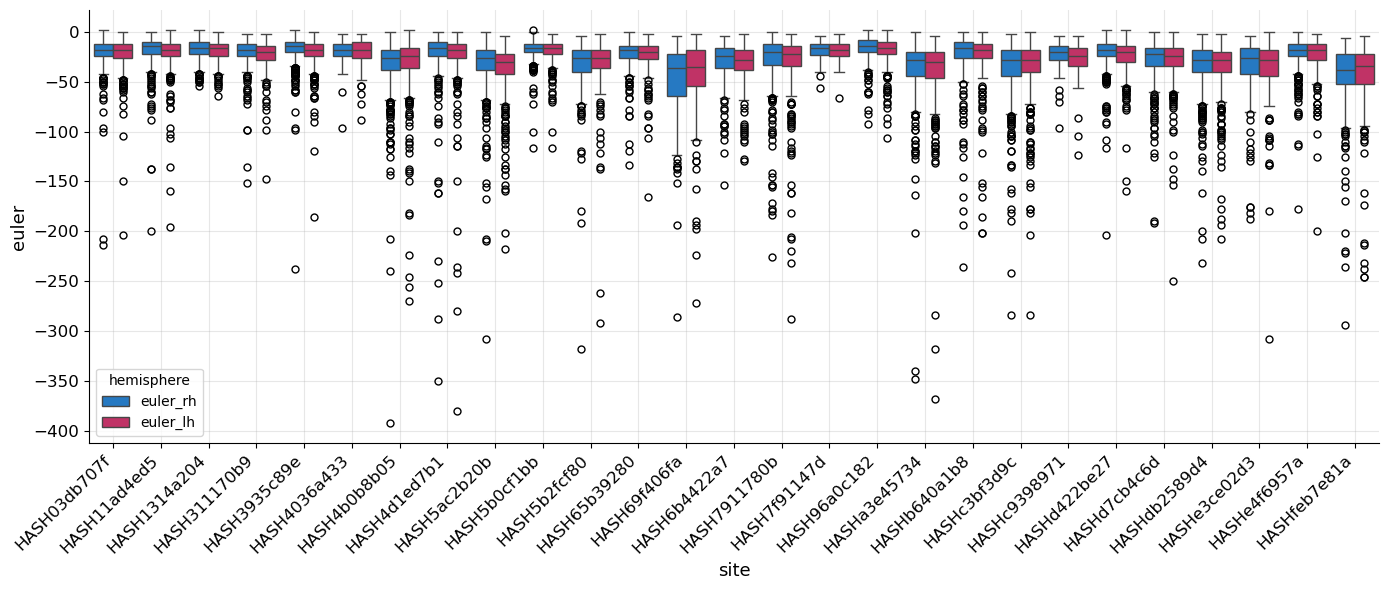

In [19]:
flierprops = dict(marker='o', markerfacecolor='None', markersize=5,  markeredgecolor='black')

# compute the standard deviation within each site
sds = incl_2year[['site', 'euler_lh', 'euler_rh']].groupby('site').std()

euler_data = incl_2year[['site','euler_lh','euler_rh']].melt(id_vars='site', value_vars=['euler_lh', 'euler_rh'], 
                                                              var_name = 'hemisphere', value_name = 'euler')

# boxplots for the distributions of euler numbers of each site for left (red) and right (red) hemisphere
fig, axes = plt.subplots(figsize=(14, 6))
sns.boxplot(ax=axes, data=euler_data.sort_values('site'), x='site', y='euler', 
            hue='hemisphere', palette=colors, flierprops=flierprops);
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha="right");
axes.grid(alpha=.3)
utils.remove_axes(axes)
fig.tight_layout()
plt.savefig(f'plots/{atlas_to_use}/euler_before_2yr.pdf', transparent=False, dpi=300)

In [20]:
# check how many subjects we would remove with 3-5 SDs
sds = [3, 4, 5, 6]
df = pd.DataFrame(columns=['SD','n_remaining', 'prct_excluded'])

for i, sd in enumerate(sds):
    
    data = demographics.copy()
    this_sd = data[['site', 'euler_lh', 'euler_rh']].groupby('site').std()*sd
    
    for s, site in enumerate(this_sd.index):
        a = np.abs(data[data.site == site].euler_lh) > this_sd.iloc[s, 0] 
        b = np.abs(data[data.site == site].euler_rh) > this_sd.iloc[s, 1] 
        # we want to exclude if either left or right hemisphere is bad
        to_remove = a | b 
        #print("Excluding", np.sum(to_remove), "/", len(to_remove), "subjects for site: ", site)
        data.drop(to_remove.index[to_remove==True], axis=0, inplace=True)

    # exclude all those that then have only one scan left
    data = data.loc[data['src_subject_id'].map(data['src_subject_id'].value_counts()) == 2].reset_index(drop=True)
    df.loc[i] = [sd, len(data)/2, (1-(len(data)/2)/(len(demographics)/2))*100]

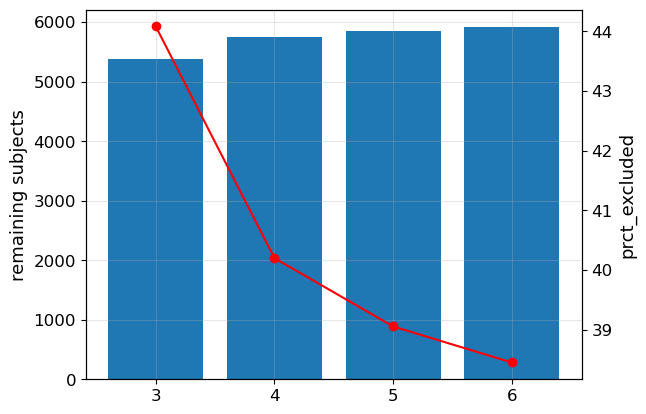

In [21]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(df.SD, df.n_remaining)
ax1.grid(alpha=.3)
ax2.plot(df.SD, df.prct_excluded, color='r', marker='o')
ax1.set_xticks(df.SD)

ax2.set_ylabel('prct_excluded')
ax1.set_ylabel('remaining subjects')
plt.show();

/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_58275/3223769715.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha="right");


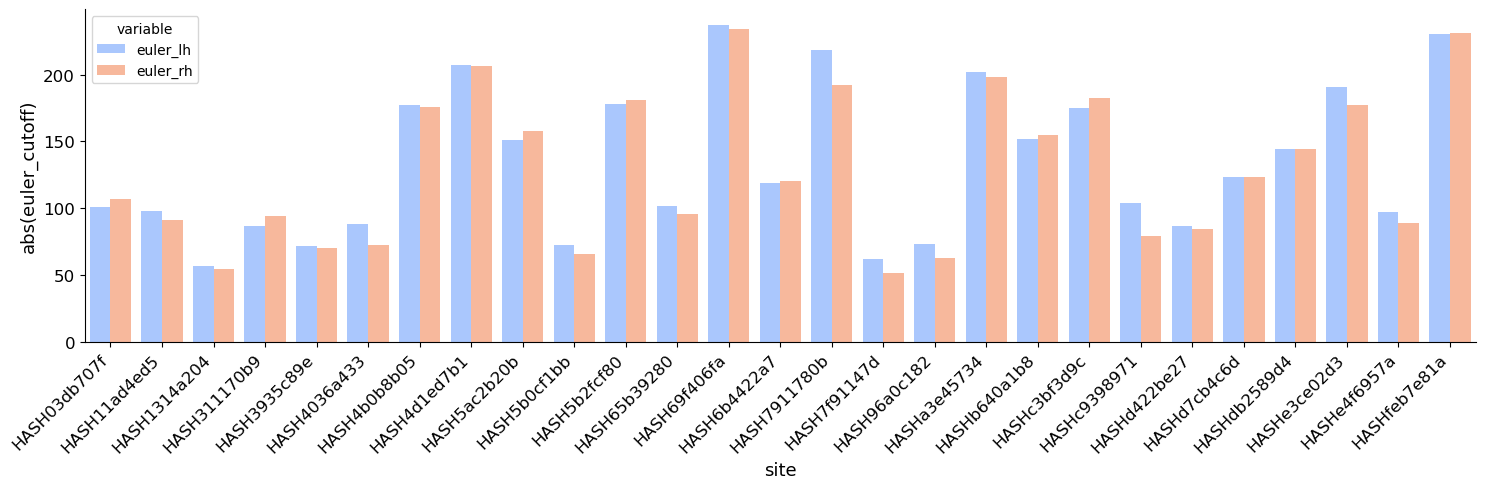

In [22]:
cutoff_sd = 6
this_sd = incl_2year[['site', 'euler_lh', 'euler_rh']].groupby('site').std()*cutoff_sd
this_sd = this_sd.reset_index() 
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(ax=axes, data=this_sd.melt(id_vars='site', value_name='abs(euler_cutoff)'), 
            x='site', hue='variable', y='abs(euler_cutoff)', palette='coolwarm', saturation=1)
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha="right");
utils.remove_axes(axes)

fig.tight_layout()
plt.savefig('plots/euler_cutoff.pdf', transparent=False, dpi=300)

5434.0


/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_58275/321497849.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha="right");


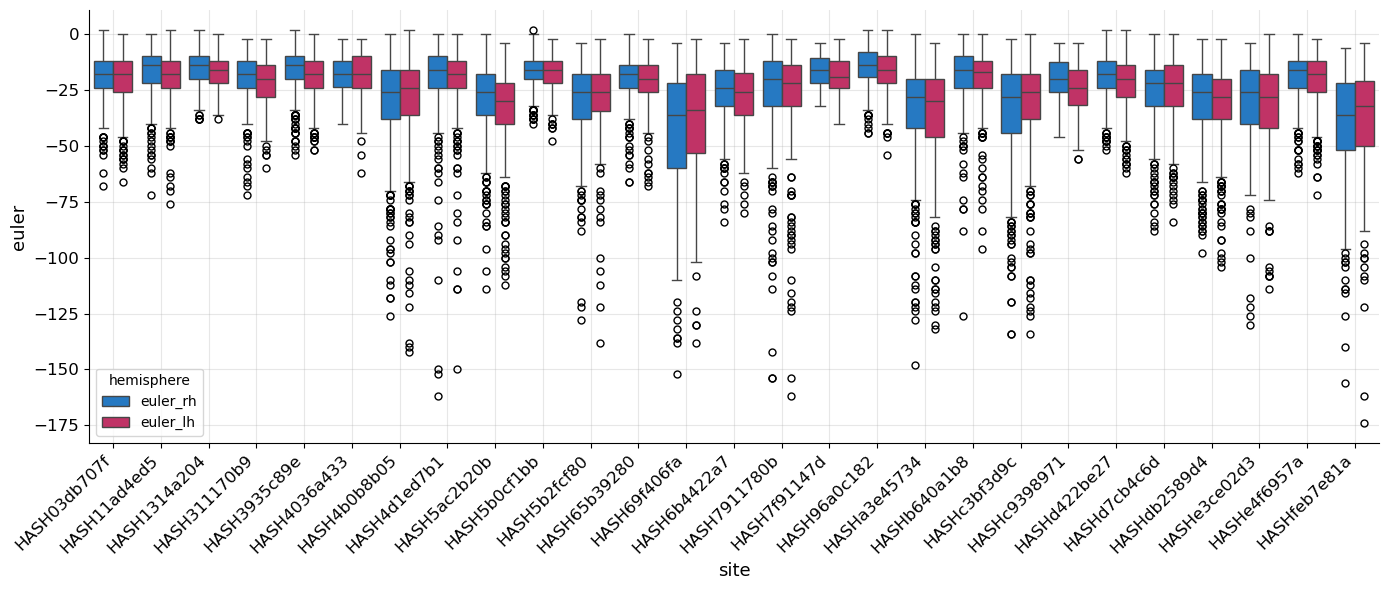

In [23]:
# LETS REMOVE ALL WITH AN SD OF 6
csd = 6

this_mean = incl_2year[['site', 'euler_lh', 'euler_rh']].groupby('site').mean()
this_sd = incl_2year[['site', 'euler_lh', 'euler_rh']].groupby('site').std()*csd

for s, site in enumerate(this_sd.index):
    a = np.abs(incl_2year[incl_2year.site == site].euler_lh) > (this_mean.iloc[s, 0] + this_sd.iloc[s, 0])
    b = np.abs(incl_2year[incl_2year.site == site].euler_rh) > (this_mean.iloc[s, 1] + this_sd.iloc[s, 1]) 
    # we want to exclude if either left or right hemisphere is bad
    to_remove = a | b 
    incl_2year.drop(to_remove.index[to_remove==True], axis=0, inplace=True)

# exclude all those that then have only one scan left
incl_2year = incl_2year.loc[incl_2year['src_subject_id'].map(incl_2year['src_subject_id'].value_counts()) == 2].reset_index(drop=True)
print(len(incl_2year)/2)

# plot the euler numbers again
euler_data = incl_2year[['site','euler_lh','euler_rh']].melt(id_vars='site', value_vars=['euler_lh', 'euler_rh'], 
                                                              var_name = 'hemisphere', value_name = 'euler')
fig, axes = plt.subplots(figsize=(14, 6), sharex=True)
sns.boxplot(ax=axes, data=euler_data.sort_values('site'), x='site', y='euler', 
            hue='hemisphere', palette=colors, flierprops=flierprops);
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha="right");
axes.grid(alpha=.3)
utils.remove_axes(axes)
fig.tight_layout()
plt.savefig(f'plots/{atlas_to_use}/euler_after_2yr.pdf', transparent=False, dpi=300)

We'll now remove all those participants who have unusal cortical thickness values within any Glass region-of-interest.

In [24]:
# loop over the ROIs and check which participants fall out of 6SD of cortical thickness.
csd = 6
outliers = []
for r, roi in enumerate(ROI_lbls):
    this_mean = incl_2year[roi].mean()
    this_sd = incl_2year[roi].std()*csd
    cutoff = this_mean + this_sd
    
    outliers.extend(incl_2year[incl_2year[roi] > cutoff].src_subject_id.tolist())

outliers = np.unique(outliers)

incl_2year = incl_2year[~incl_2year.src_subject_id.isin(outliers)]
# we have only 3 subjects in one site. this leads to some issues later. drop them too.
incl_2year = incl_2year[~(incl_2year.site=='HASHe76e6d72')]
incl_2year = incl_2year.loc[incl_2year['src_subject_id'].map(incl_2year['src_subject_id'].value_counts()) == 2].reset_index(drop=True)
incl_2year.groupby(['eventname', 'sex']).describe()

NameError: name 'ROI_lbls' is not defined

### Combine the demographics with the thickness data and save it into a CSV file

In [ ]:
atlas_out_dir = f'data/{atlas_to_use}'
if not os.path.exists(atlas_out_dir):
    os.makedirs(atlas_out_dir, exist_ok=True)

incl_2year.columns = incl_2year.columns.str.replace('_thickness', '') # remove '_thickness' from the roi column labels
incl_2year.columns = incl_2year.columns.str.replace('_ROI', '') # remove '_ROI' from the roi column labels; not all of them have this
incl_2year.rename(columns={"lh_???": "lh_avg", "rh_???": "rh_avg"}, inplace=True) # the '???' lead to issues
incl_2year.to_csv(os.path.join(atlas_out_dir, 'combined_features_2yr.csv'), index=False)

### Adjust the 4year test data

We perform the same steps as above for those participants having only bl- and 2-year data.

In [ ]:
incl_4year.groupby(['eventname', 'sex']).describe()

In [ ]:
unique_sites = incl_2year.site.unique().tolist()

incl_4year = incl_4year[incl_4year.site.isin(unique_sites)].reset_index(drop=True)
incl_4year = incl_4year.loc[incl_4year['src_subject_id'].map(incl_4year['src_subject_id'].value_counts()) == 3].reset_index(drop=True)

sds = incl_4year[['site', 'euler_lh', 'euler_rh']].groupby('site').std()
euler_data = incl_4year[['site','euler_lh','euler_rh']].melt(id_vars='site', value_vars=['euler_lh', 'euler_rh'], 
                                                              var_name = 'hemisphere', value_name = 'euler')

# plot the 4 year euler data
fig, axes = plt.subplots(figsize=(14, 6), sharex=True)
sns.boxplot(ax=axes, data=euler_data.sort_values('site'), x='site', y='euler', 
            hue='hemisphere', palette=colors, flierprops=flierprops);
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha="right");
axes.grid(alpha=.3)
utils.remove_axes(axes)
fig.tight_layout()
plt.savefig(f'plots/{atlas_to_use}/euler_before_4yr.pdf', transparent=False, dpi=300)

# LETS REMOVE ALL DATAPOINTS WITH AN VALUE > MEAN+6*SD
cutoff_sd = 6
this_mean = incl_4year[['site', 'euler_lh', 'euler_rh']].groupby('site').mean()
this_sd = incl_4year[['site', 'euler_lh', 'euler_rh']].groupby('site').std()*cutoff_sd

for s, site in enumerate(this_sd.index):
    a = np.abs(incl_4year[incl_4year.site == site].euler_lh) > (this_mean.iloc[s, 0] + this_sd.iloc[s, 0])
    b = np.abs(incl_4year[incl_4year.site == site].euler_rh) > (this_mean.iloc[s, 1] + this_sd.iloc[s, 1]) 
    # we want to exclude if either left or right hemisphere is bad
    to_remove = a | b 
    incl_4year.drop(to_remove.index[to_remove==True], axis=0, inplace=True)

# exclude all those that then have only one scan left
incl_4year = incl_4year.loc[incl_4year['src_subject_id'].map(incl_4year['src_subject_id'].value_counts()) == 3].reset_index(drop=True)

# plot the euler numbers again
euler_data = incl_4year[['site','euler_lh','euler_rh']].melt(id_vars='site', value_vars=['euler_lh', 'euler_rh'], 
                                                              var_name = 'hemisphere', value_name = 'euler')
fig, axes = plt.subplots(figsize=(14, 6), sharex=True)
sns.boxplot(ax=axes, data=euler_data.sort_values('site'), x='site', y='euler', 
            hue='hemisphere', palette=colors, flierprops=flierprops);
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha="right");
axes.grid(alpha=.3)
utils.remove_axes(axes)
fig.tight_layout()
plt.savefig(f'plots/{atlas_to_use}/euler_after_4yr.pdf', transparent=False, dpi=300)

# loop over the ROIs and check which participants fall out of 6SD for cortical thickness.
outliers = []
for r, roi in enumerate(ROI_lbls):
    this_mean = incl_4year[roi].mean()
    this_sd = 6*incl_4year[roi].std()
    cutoff = this_mean + this_sd
    
    outliers.extend(incl_4year[incl_4year[roi] > cutoff].src_subject_id.tolist())

outliers = np.unique(outliers)

incl_4year = incl_4year[~incl_4year.src_subject_id.isin(outliers)]
# we have only 3 subjects in one site. this leads to some issues later. drop them too.
incl_4year = incl_4year[~(incl_4year.site=='HASHe76e6d72')]
incl_4year = incl_4year.loc[incl_4year['src_subject_id'].map(incl_4year['src_subject_id'].value_counts()) == 3].reset_index(drop=True)
print(len(incl_4year)/3)

In [ ]:
atlas_out_dir = f'data/{atlas_to_use}'
if not os.path.exists(atlas_out_dir):
    os.makedirs(atlas_out_dir, exist_ok=True)

incl_4year.columns = incl_4year.columns.str.replace('_thickness','') # remove '_thickness' from the roi column labels
incl_4year.columns = incl_4year.columns.str.replace('_ROI','') # remove '_ROI' from the roi column labels; not all of them have this
incl_4year.rename(columns={"lh_???": "lh_avg", "rh_???": "rh_avg"}, inplace=True)
incl_4year.to_csv(os.path.join(atlas_out_dir, 'combined_features_4yr.csv'), index=False)
incl_4year.groupby(['eventname', 'sex']).describe()

# Check if the average thickness goes down in timepoint two

In [ ]:
df_2yr = pd.read_csv(os.path.join(atlas_out_dir, 'combined_features_2yr.csv'))
df_2yr.sex = df_2yr.sex.map({1.0: 'M', 2.0: 'F'})

df_4yr = pd.read_csv(os.path.join(atlas_out_dir, 'combined_features_4yr.csv'))
df_4yr.sex = df_4yr.sex.map({1.0: 'M', 2.0: 'F'})

In [ ]:
sns.set(style='whitegrid')
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# age distribution training set
sns.boxplot(ax=axes[0], data=df_2yr, x='eventname', y='age', hue='sex', 
            order=["baselineyear1arm1", "2yearfollowupyarm1"], 
            palette=colors, flierprops=flierprops)
sns.stripplot(ax=axes[0], data=df_2yr, x='eventname', y='age', hue='sex', 
              dodge=True, alpha=.2, legend=False, palette=colors,
              order=["baselineyear1arm1", "2yearfollowupyarm1"])

axes[0].set_title('Age distribution: training set', fontsize=22)
axes[0].legend(fontsize=20)

# age distribution test test
sns.boxplot(ax=axes[1], data=df_4yr, x='eventname', y='age', hue='sex', 
            palette=colors, flierprops=flierprops, 
            order=["baselineyear1arm1", "2yearfollowupyarm1", "4yearfollowupyarm1"])
sns.stripplot(ax=axes[1], data=df_4yr, x='eventname', y='age', hue='sex', 
              dodge=True, alpha=.2, legend=False, palette=colors,
              order=["baselineyear1arm1", "2yearfollowupyarm1", "4yearfollowupyarm1"])

axes[1].set_title('Age distribution: test set', fontsize=22)
axes[1].legend(fontsize=20)

sns.set(style='white')
plt.savefig(f"plots/age_boxplots.pdf")

In [ ]:
# histograms of age separated by sex
to_plot = df_2yr[['eventname', 'sex', 'age']].copy()
g = sns.displot(data=to_plot, x='age', hue='eventname', kde=True, col='sex', col_order=['M', 'F'])
g.set(xlabel='age (in months)')
plt.savefig("plots/age_sex_dist_2yr.pdf", transparent=False, dpi=300)

# those participants with bl, 2nd-, and 4th year
to_plot = df_4yr[['eventname', 'sex', 'age']].copy()
g = sns.displot(data=to_plot, x='age', hue='eventname', kde=True, col='sex', col_order=['M', 'F'])
g.set(xlabel='age (in months)')
plt.savefig(f"plots/age_sex_dist_4yr.pdf", transparent=False, dpi=300)

We would expect that average cortical thickness goes down over time while average PDS goes up. 

Let's check if our data actually reflects that: 

In [ ]:
df_2yr['avg_thickness'] = df_2yr.iloc[:,13:].mean(axis=1)
df_4yr['avg_thickness'] = df_4yr.iloc[:,13:].mean(axis=1)

In [ ]:
sns.set(style='whitegrid')
hue_order = ['M', 'F']
x_order = ['baselineyear1arm1', '2yearfollowupyarm1', '4yearfollowupyarm1']

## average cortical thickness
fig, axes = plt.subplots(1,2,figsize=(15, 5), sharey=True)

# participants with BL- and 2-year data
sns.boxplot(ax=axes[0], data=df_2yr, x='eventname', y='avg_thickness', hue='sex', 
            hue_order=hue_order, palette=colors, saturation=1, order=x_order[:2], 
            flierprops=flierprops)
sns.stripplot(ax=axes[0], data=df_2yr, x='eventname', y='avg_thickness', hue='sex', 
              hue_order=hue_order, palette=colors, dodge=True, alpha=.1, legend=False)
axes[0].set_title('Thickness for participants with BL, 2-year follow-up');

# participants with BL-, 2-, and 4-year data
sns.boxplot(ax=axes[1], data=df_4yr, x='eventname', y='avg_thickness', hue='sex', 
            hue_order=hue_order, palette=colors, saturation=1, order=x_order, 
            flierprops=flierprops)
sns.stripplot(ax=axes[1], data=df_4yr, x='eventname', y='avg_thickness', hue='sex', 
              hue_order=hue_order, palette=colors, dodge=True, alpha=.1, legend=False)
axes[1].set_title('Thickness for participants with BL, 2-, and 4-year follow-up');

utils.remove_axes(axes)
plt.savefig(f"plots/{atlas_to_use}/avg_thickness.pdf", transparent=False, dpi=300)

## average PDS
# we would expect that PDS increases faster and more for females than males.
hue_order = ['M', 'F']
x_order = ['baselineyear1arm1', '2yearfollowupyarm1', '4yearfollowupyarm1']
fig, axes = plt.subplots(1,2,figsize=(15, 5), sharey=True)

# participants with BL- and 2-year data
sns.stripplot(ax=axes[0], data=df_2yr, x='eventname', y='PDS_mean_p', hue='sex', 
              hue_order=hue_order, palette=colors, dodge=True, alpha=.1, legend=False)
sns.boxplot(ax=axes[0], data=df_2yr, x='eventname', y='PDS_mean_p', hue='sex', 
            hue_order=hue_order, palette=colors, saturation=1, order=x_order[:2], 
            flierprops=flierprops)
axes[0].set_title('PDS Scores for participants with BL and 2-year follow-up');

# participants with BL-, 2-, and 4-year data
sns.boxplot(ax=axes[1], data=df_4yr, x='eventname', y='PDS_mean_p', hue='sex', 
            hue_order=hue_order, palette=colors, saturation=1, order=x_order, 
            flierprops=flierprops)
sns.stripplot(ax=axes[1], data=df_4yr, x='eventname', y='PDS_mean_p', hue='sex', 
              hue_order=hue_order, palette=colors, dodge=True, alpha=.1, legend=False)
axes[1].set_title('PDS Scores for participants with BL, 2-, and 4-year follow-up');

utils.remove_axes(axes)
plt.savefig(f"plots/{atlas_to_use}/avg_PDS.pdf", transparent=False, dpi=300)

sns.set(style='white')

We should also take a look at the BMI data.

In [ ]:
sns.set(style='whitegrid')
hue_order = ['M', 'F']
x_order = ['baselineyear1arm1', '2yearfollowupyarm1', '4yearfollowupyarm1']

## show some BMI graphs
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# participants with BL-, 2-year data
sns.boxplot(ax=axes[0], data=df_2yr, x='eventname', y='bmi', hue='sex', 
            hue_order=hue_order, palette=colors, saturation=1, order=x_order[:2], 
            flierprops=flierprops)
sns.stripplot(ax=axes[0], data=df_2yr, x='eventname', y='bmi', hue='sex', 
              hue_order=hue_order, palette=colors, dodge=True, alpha=.1, legend=False)
axes[0].set_title('BMI for participants with BL, 2-year follow-up');

# participants with BL-, 2-, and 4-year data
sns.boxplot(ax=axes[1], data=df_4yr, x='eventname', y='bmi', hue='sex', 
            hue_order=hue_order, palette=colors, saturation=1, order=x_order, 
            flierprops=flierprops)
sns.stripplot(ax=axes[1], data=df_4yr, x='eventname', y='bmi', hue='sex', 
              hue_order=hue_order, palette=colors, dodge=True, alpha=.1, legend=False)
axes[1].set_title('BMI for participants with BL, 2-, and 4-year follow-up');

utils.remove_axes(axes)
sns.set(style='white')

plt.savefig(f"plots/{atlas_to_use}/avg_bmi.pdf", transparent=False, dpi=300)

Lastly, let us check what the ethnical distribution of our data looks like. 

In [ ]:
sns.set(style='whitegrid')
dfs = [df_2yr[df_2yr.eventname == 'baselineyear1arm1'], 
       df_4yr[df_4yr.eventname == 'baselineyear1arm1']]

ethnicities = ['White', 'Black', 'Hispanic', 'Asian', 'Other']

titles = ['Participants with BL and 2-year follow-up',
          'Participants with BL, 2-, and 4-year follow-up']

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
for i, df in enumerate(dfs):
    sex_race = df[['sex', 'race_ethnicity']].copy()
    sex_race.replace({float(x+1): ethnicities[x] for x in range(len(ethnicities))}, inplace=True)
    
    ax = sns.countplot(ax=axes[i], data=sex_race, x='race_ethnicity', hue='sex', 
                       palette=colors, saturation=1, order=ethnicities)
    for j in ax.containers:
        ax.bar_label(j,)

    axes[i].set_title(titles[i]);

plt.savefig(f"plots/{atlas_to_use}/ethnicity.pdf", transparent=False, dpi=300)
sns.set(style='white')

# CREATE THE TRAIN AND TEST SPLITS

Let us first reshape the data so we can extract all train/testing data easily by the suffixes "_bl/2yr/4yr"

In [ ]:
from utils import reshape_data
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit

In [ ]:
# load the data for participants with 2 sessions
df_2yr = pd.read_csv(f'data/{atlas_to_use}/combined_features_2yr.csv')
df_2yr.columns = df_2yr.columns.str.replace('_thickness','') # remove '_thickness' from the roi column labels
df_2yr.columns = df_2yr.columns.str.replace('_ROI','') # remove '_ROI' from the roi column labels; not all of them have this
df_2yr.rename(columns={"lh_???": "lh_avg", "rh_???": "rh_avg"}, inplace=True)

# get the site ids in a list and the ROI-label ids
site_list = df_2yr.site.unique().tolist()
ROI_lbls = df_2yr.columns[15:]
    
# load the data for participants with 3 sessions
df_4yr = pd.read_csv(f'data/{atlas_to_use}/combined_features_4yr.csv')
df_4yr.columns = df_4yr.columns.str.replace('_thickness','') # remove '_thickness' from the roi column labels
df_4yr.columns = df_4yr.columns.str.replace('_ROI','') # remove '_ROI' from the roi column labels; not all of them have this

# reshape the data so it is a bit easier to handle
rdf_2yr = reshape_data(df_2yr)
rdf_2yr.to_csv(f'data/{atlas_to_use}/2year_only_reshaped.csv', index=False)
rdf_4yr = reshape_data(df_4yr)
rdf_4yr.to_csv(f'data/{atlas_to_use}/4year_reshaped.csv', index=False)

In [ ]:
# create train-test splits for cross-validation for those participants with only BL and 2-year follow-up data
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

sexes = ['male', 'female']

for s, sex in enumerate(["full", 1, 2]):
    to_split = rdf_2yr[rdf_2yr.sex_bl == sex].reset_index(drop=True) if s > 0 else rdf_2yr
    print(len(to_split))

    # stratify based on site; the x variable in principle is irrelevant
    for i, (train_idx, test_idx) in enumerate(splitter.split(to_split.src_subject_id, to_split.site_bl.values)): 
        tbl_train, tbl_test = {}, {}
        tbl_train["index"] = train_idx
        tbl_test["index"] = test_idx        

        pd.DataFrame(tbl_train).to_csv(f'data/glasser/{"full" if s == 0 else sexes[sex-1]}_train_idcs_fold{i}.csv', index=False)
        pd.DataFrame(tbl_test).to_csv(f'data/glasser/{"full" if s == 0 else sexes[sex-1]}_test_idcs_fold{i}.csv', index=False)


In [ ]:
x_train, x_test, _, _ = train_test_split(rdf_2yr, rdf_2yr, stratify=rdf_2yr['site_bl'], test_size=.2, random_state=42)
print(len(x_train), len(x_test))
x_train.to_csv(os.path.join("data/train_full_f1.csv"))
x_test.to_csv(os.path.join("data/test_full_f1.csv"))
# the data including the 4year (i.e., the t2 data) 
rdf_4yr.to_csv(os.path.join("data/test_full_f2.csv"))

# now let's do the same for the (fe)males only
for i, sex in enumerate(["male", "female"]):
    sex_id = 1.0 if sex == 'male' else 2.0

    this_df = rdf_2yr[rdf_2yr.sex_bl == sex_id]
    x_train, x_test, _, _ = train_test_split(this_df, this_df, stratify=this_df['site_bl'], test_size=.2, random_state=42)
    x_train.to_csv(os.path.join(f"data/train_{sex}_f1.csv"))
    x_test.to_csv(os.path.join(f"data/test_{sex}_f1.csv"))
    # the data including the 4year (i.e., the t2 data) 
    rdf_4yr[rdf_4yr.sex_bl == sex_id].to_csv(os.path.join(f"data/test_{sex}_f2.csv"))

In [ ]:
sexes = ["male", "female"]
for f in ["f1", "f2"]:
    ds = pd.read_csv(f"./data/test_full_{f}.csv")
    for s in [1, 2]:
        selected = ds[ds.sex_bl == s]
        selected.to_csv(f"./data/test_full_{sexes[s-1]}_{f}.csv", index=False)